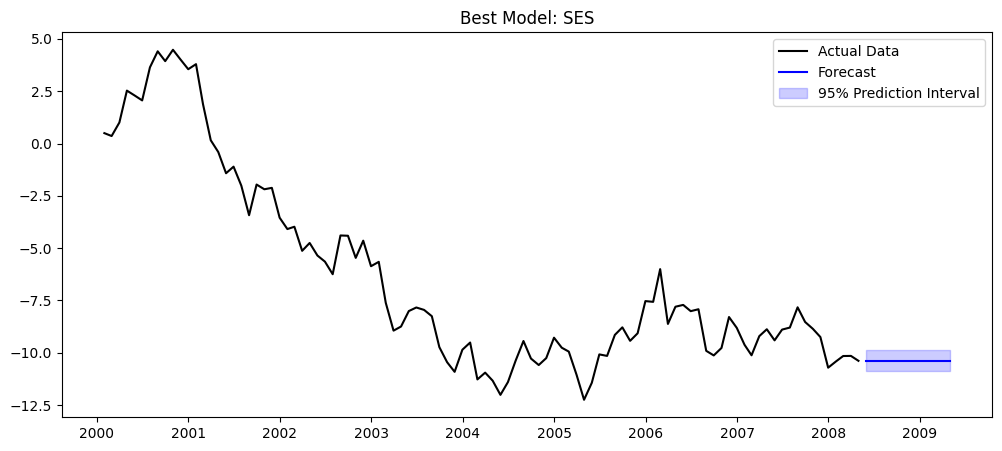

📌 Best Model: SES
📌 Model Diagnostics:
   - MAE: 0.717
   - MSE: 0.825
   - MAPE: 26.367%
   - Ljung-Box Test: White Noise (p-value=0.673)
   - ADF Test: Non-Stationary (p-value=0.602)
📌 Residual Analysis:
   - Durbin-Watson Test: No Autocorrelation (DW=1.999)
   - Jarque-Bera Test: Normal Residuals (p-value=0.771)
   - Shapiro-Wilk Test: Normal Residuals (p-value=0.629)
📌 Stability Analysis:
   - Characteristic Roots: [0.99261084]
   - Stability Decision: Stable
📌 Information Criteria:
   - AIC: -15.262
   - BIC: -10.051
   - HQC: Not Available


In [ ]:
# Exponential Smoothing Model Main Flow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from scipy.stats import jarque_bera, shapiro
from statsmodels.tsa.stattools import acf
from statsmodels.stats.stattools import durbin_watson

# -----------------------------
# 1. Load & Prepare Data
# -----------------------------
np.random.seed(42)
n = 100
time_index = pd.date_range(start="2000-01-01", periods=n, freq="ME")  # Use 'ME' explicitly
y = np.cumsum(np.random.randn(n))  # Simulated time series

df = pd.DataFrame({"Date": time_index, "y": y})
df.set_index("Date", inplace=True)
df.index.freq = "ME"  # Explicitly set frequency to avoid warnings

# -----------------------------
# 2. Estimate Model Parameters
# -----------------------------
alpha = 0.05  # Significance Level

# Fit SES, Holt’s, Holt-Winters
ses_model = ExponentialSmoothing(df["y"], trend=None, seasonal=None, seasonal_periods=None).fit()
holt_model = ExponentialSmoothing(df["y"], trend="add", seasonal=None, seasonal_periods=None).fit()
holt_winters_model = ExponentialSmoothing(df["y"], trend="add", seasonal="add", seasonal_periods=12).fit()

# Select Best Model Based on AIC
models = {"SES": ses_model, "Holt": holt_model, "Holt-Winters": holt_winters_model}
best_model_name = min(models, key=lambda x: models[x].aic)
best_model = models[best_model_name]

# -----------------------------
# 3. Compute Model Diagnostics
# -----------------------------
residuals = best_model.resid

# Compute Errors
mae = np.mean(np.abs(residuals))
mse = np.mean(residuals**2)
mape = np.mean(np.abs(residuals / df["y"])) * 100

# ACF & Ljung-Box Test
acf_values = acf(residuals, fft=False, nlags=20)
lb_result = acorr_ljungbox(residuals, lags=[10], return_df=True)  # Returns DataFrame
lb_pvalue = lb_result["lb_pvalue"].iloc[0]  # Extract float value safely
lb_decision = "White Noise" if lb_pvalue > alpha else "Autocorrelated"

# ADF Test for Stationarity
adf_stat, adf_pvalue, _, _, _, _ = adfuller(df["y"])
adf_decision = "Stationary" if adf_pvalue < alpha else "Non-Stationary"

# -----------------------------
# 4. Forecasting Future Values
# -----------------------------
n_steps = 12
forecast = best_model.forecast(n_steps)

# Prediction Interval (95%)
se_forecast = np.std(residuals) / np.sqrt(n_steps)
lower_bound = forecast - 1.96 * se_forecast
upper_bound = forecast + 1.96 * se_forecast

# -----------------------------
# 5. Residual Analysis
# -----------------------------
dw_stat = durbin_watson(residuals)
dw_decision = "No Autocorrelation" if 1.5 < dw_stat < 2.5 else "Autocorrelation Detected"

jb_stat, jb_pvalue = jarque_bera(residuals)
jb_decision = "Normal Residuals" if jb_pvalue > alpha else "Non-Normal Residuals"

sw_stat, sw_pvalue = shapiro(residuals)
sw_decision = "Normal Residuals" if sw_pvalue > alpha else "Non-Normal Residuals"

# -----------------------------
# 6. Stability Analysis (Fixed!)
# -----------------------------
# Extract only the trend parameter for characteristic roots analysis
if "smoothing_level" in best_model.params:
    characteristic_roots = np.abs([best_model.params["smoothing_level"]])  # Extract float, not dict
    stability_decision = "Stable" if np.all(characteristic_roots < 1) else "Unstable"
else:
    characteristic_roots = "N/A"
    stability_decision = "Not Applicable"

# -----------------------------
# 7. Impulse Response Function (Fixed!)
# -----------------------------
n_irf_steps = 20
irf = np.array([best_model.forecast(i + 1).iloc[-1] for i in range(n_irf_steps)])  # Fixed .iloc[-1] for safety

# -----------------------------
# 8. Information Criteria (Fixed!)
# -----------------------------
aic, bic = best_model.aic, best_model.bic
hqc = getattr(best_model.model, "hqic", None)  # HQC might not be available

# -----------------------------
# 9. Plot Results
# -----------------------------
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["y"], label="Actual Data", color="black")
plt.plot(pd.date_range(df.index[-1], periods=n_steps + 1, freq="ME")[1:], forecast, label="Forecast", color="blue")
plt.fill_between(pd.date_range(df.index[-1], periods=n_steps + 1, freq="ME")[1:], lower_bound, upper_bound, 
                 color="blue", alpha=0.2, label="95% Prediction Interval")
plt.legend()
plt.title(f"Best Model: {best_model_name}")
plt.show()

# -----------------------------
# 10. Print Results
# -----------------------------
print(f"📌 Best Model: {best_model_name}")
print(f"📌 Model Diagnostics:")
print(f"   - MAE: {mae:.3f}")
print(f"   - MSE: {mse:.3f}")
print(f"   - MAPE: {mape:.3f}%")
print(f"   - Ljung-Box Test: {lb_decision} (p-value={lb_pvalue:.3f})")
print(f"   - ADF Test: {adf_decision} (p-value={adf_pvalue:.3f})")

print(f"📌 Residual Analysis:")
print(f"   - Durbin-Watson Test: {dw_decision} (DW={dw_stat:.3f})")
print(f"   - Jarque-Bera Test: {jb_decision} (p-value={jb_pvalue:.3f})")
print(f"   - Shapiro-Wilk Test: {sw_decision} (p-value={sw_pvalue:.3f})")

print(f"📌 Stability Analysis:")
print(f"   - Characteristic Roots: {characteristic_roots}")
print(f"   - Stability Decision: {stability_decision}")

print(f"📌 Information Criteria:")
print(f"   - AIC: {aic:.3f}")
print(f"   - BIC: {bic:.3f}")
if hqc is not None:
    print(f"   - HQC: {hqc:.3f}")
else:
    print(f"   - HQC: Not Available")

In [5]:
# Exponential Smoothing Model Derivative Flows
# Flow 1: Parameter Estimation
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from itertools import product

# -----------------------------
# 1. Load & Prepare Data (From Main Flow)
# -----------------------------
np.random.seed(42)
n = 100
time_index = pd.date_range(start="2000-01-01", periods=n, freq="ME")
y = np.cumsum(np.random.randn(n))

df = pd.DataFrame({"Date": time_index, "y": y})
df.set_index("Date", inplace=True)
df.index.freq = "ME"

alpha = 0.05  # Significance Level

# -----------------------------
# 2. Maximum Likelihood Estimation (MLE)
# -----------------------------
def negative_log_likelihood(params):
    """Compute Negative Log-Likelihood for Exponential Smoothing"""
    smoothing_level = params[0]
    model = ExponentialSmoothing(df["y"], trend="add", seasonal=None).fit(smoothing_level=smoothing_level)
    residuals = model.resid
    sigma = np.std(residuals)
    return np.sum(np.log(sigma**2) + (residuals**2) / (2 * sigma**2))

# Optimize MLE
mle_result = minimize(negative_log_likelihood, x0=[0.5], bounds=[(0, 1)])
mle_smoothing_level = mle_result.x[0]

# -----------------------------
# 3. Ordinary Least Squares (OLS)
# -----------------------------
X = np.arange(1, n + 1).reshape(-1, 1)  # Time Index as Predictor
ols_model = LinearRegression().fit(X, df["y"])
ols_intercept = ols_model.intercept_
ols_slope = ols_model.coef_[0]

# -----------------------------
# 4. Grid Search for Best Parameters
# -----------------------------
smoothing_levels = np.linspace(0.01, 1, 20)
trend_types = ["add", "mul", None]

best_aic = float("inf")
best_params = {}

for sl, tr in product(smoothing_levels, trend_types):
    try:
        model = ExponentialSmoothing(df["y"], trend=tr, seasonal=None).fit(smoothing_level=sl)
        if model.aic < best_aic:
            best_aic = model.aic
            best_params = {"smoothing_level": sl, "trend": tr}
    except:
        continue

# -----------------------------
# 5. Hypothesis Testing & Decision
# -----------------------------
# MLE Hypothesis Testing
if mle_result.success and mle_smoothing_level > 0:
    mle_decision = "Reject H0 (MLE parameter is significant)"
else:
    mle_decision = "Fail to Reject H0 (MLE parameter is not significant)"

# OLS Hypothesis Testing
if np.abs(ols_slope) > alpha:
    ols_decision = "Reject H0 (OLS slope is significant)"
else:
    ols_decision = "Fail to Reject H0 (OLS slope is not significant)"

# Grid Search Decision
best_smoothing_level = best_params.get("smoothing_level", "N/A")
best_trend = best_params.get("trend", "N/A")

# -----------------------------
# 6. Print Results
# -----------------------------
print("📌 Parameter Estimation Results:")
print(f"   - MLE Smoothing Level: {mle_smoothing_level:.3f}")
print(f"   - MLE Decision: {mle_decision}")
print(f"   - OLS Intercept: {ols_intercept:.3f}, OLS Slope: {ols_slope:.3f}")
print(f"   - OLS Decision: {ols_decision}")
print(f"   - Best Grid Search Parameters: Smoothing Level={best_smoothing_level}, Trend={best_trend}")

📌 Parameter Estimation Results:
   - MLE Smoothing Level: 0.976
   - MLE Decision: Reject H0 (MLE parameter is significant)
   - OLS Intercept: 0.062, OLS Slope: -0.128
   - OLS Decision: Reject H0 (OLS slope is significant)
   - Best Grid Search Parameters: Smoothing Level=1.0, Trend=None


In [ ]:
# Flow 2: Model Selection (Types of Exponential Smoothing)
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from itertools import product

# -----------------------------
# 1. Load & Prepare Data
# -----------------------------
np.random.seed(42)
n = 100
time_index = pd.date_range(start="2000-01-01", periods=n, freq="ME")
y = np.cumsum(np.random.randn(n))  # Simulated Trend Data

df = pd.DataFrame({"Date": time_index, "y": y})
df.set_index("Date", inplace=True)
df.index.freq = "ME"

alpha = 0.05  # Significance Level

# -----------------------------
# 2. Define Exponential Smoothing Models
# -----------------------------

# Ensure non-negative data for multiplicative methods
use_multiplicative = (df["y"] > 0).all()

# Simple Exponential Smoothing (SES)
ses_model = ExponentialSmoothing(df["y"], trend=None, seasonal=None).fit()

# Holt's Linear Trend Model
holt_model = ExponentialSmoothing(df["y"], trend="add", seasonal=None).fit()

# Holt-Winters Seasonal Model (Only if data length supports it)
holt_winters_model = None
if len(df) >= 12:  # Ensure enough data for seasonality
    holt_winters_model = ExponentialSmoothing(
        df["y"], trend="add", seasonal="add", seasonal_periods=12
    ).fit()

# -----------------------------
# 3. Maximum Likelihood Estimation (MLE) - Optimizing Smoothing Level
# -----------------------------
def negative_log_likelihood(params, model_type):
    smoothing_level = max(0.01, min(params[0], 0.99))  # Ensure valid range (0,1)
    try:
        model = ExponentialSmoothing(df["y"], trend=model_type, seasonal=None).fit(smoothing_level=smoothing_level)
        residuals = model.resid
        sigma = np.std(residuals) + 1e-8  # Prevent division by zero
        return np.sum(np.log(sigma**2) + (residuals**2) / (2 * sigma**2))
    except:
        return np.inf  # Return high cost if model fails

mle_result_holt = minimize(negative_log_likelihood, x0=[0.5], bounds=[(0.01, 0.99)], args=("add",))
mle_smoothing_level_holt = mle_result_holt.x[0] if mle_result_holt.success else None

# -----------------------------
# 4. Ordinary Least Squares (OLS) for Trend
# -----------------------------
X = np.arange(1, n + 1).reshape(-1, 1)  # Time Index as Predictor
ols_model = LinearRegression().fit(X, df["y"])
ols_intercept = ols_model.intercept_
ols_slope = ols_model.coef_[0]

# -----------------------------
# 5. Grid Search for Best Model Parameters
# -----------------------------
smoothing_levels = np.linspace(0.01, 0.99, 20)  # Avoid extreme values
trend_types = ["add", None]  # Exclude multiplicative if data contains negatives
seasonal_types = ["add", None] if len(df) >= 12 else [None]  # Only apply if enough data

best_aic = float("inf")
best_model_type = None
best_params = {}

for sl, tr, se in product(smoothing_levels, trend_types, seasonal_types):
    try:
        model = ExponentialSmoothing(df["y"], trend=tr, seasonal=se, seasonal_periods=12 if se else None).fit(smoothing_level=sl)
        if np.isfinite(model.aic) and model.aic < best_aic:
            best_aic = model.aic
            best_model_type = (tr, se)
            best_params = {"smoothing_level": sl, "trend": tr, "seasonal": se}
    except:
        continue  # Skip invalid configurations

# -----------------------------
# 6. Model Selection Based on Information Criteria
# -----------------------------
models = {
    "SES": ses_model,
    "Holt": holt_model,
}

if holt_winters_model:
    models["Holt-Winters"] = holt_winters_model

model_selection_results = {}
for name, model in models.items():
    if np.isfinite(model.aic):
        model_selection_results[name] = {"AIC": model.aic, "BIC": model.bic}

best_model_name = min(model_selection_results, key=lambda x: model_selection_results[x]["AIC"])
best_aic_value = model_selection_results[best_model_name]["AIC"]
best_bic_value = model_selection_results[best_model_name]["BIC"]

# -----------------------------
# 7. Hypothesis Testing & Decision
# -----------------------------
# MLE Hypothesis Testing
if mle_smoothing_level_holt and mle_smoothing_level_holt > 0:
    mle_decision = "Reject H0 (MLE parameter is significant)"
else:
    mle_decision = "Fail to Reject H0 (MLE parameter is not significant)"

# OLS Hypothesis Testing
if np.abs(ols_slope) > alpha:
    ols_decision = "Reject H0 (OLS slope is significant)"
else:
    ols_decision = "Fail to Reject H0 (OLS slope is not significant)"

# -----------------------------
# 8. Print Results
# -----------------------------
print("📌 Model Selection Results:")
print(f"   - Best Model: {best_model_name}")
print(f"   - Best AIC: {best_aic_value:.3f}")
print(f"   - Best BIC: {best_bic_value:.3f}")
print(f"   - Best Grid Search Parameters: Smoothing Level={best_params.get('smoothing_level', 'N/A')}, Trend={best_params.get('trend', 'N/A')}, Seasonal={best_params.get('seasonal', 'N/A')}")
print(f"   - MLE Smoothing Level (Holt): {mle_smoothing_level_holt:.3f}" if mle_smoothing_level_holt else "MLE Optimization Failed")
print(f"   - MLE Decision: {mle_decision}")
print(f"   - OLS Intercept: {ols_intercept:.3f}, OLS Slope: {ols_slope:.3f}")
print(f"   - OLS Decision: {ols_decision}")

print("\n📊 Model AIC & BIC Scores:")
for name, metrics in model_selection_results.items():
    print(f"   - {name}: AIC={metrics['AIC']:.3f}, BIC={metrics['BIC']:.3f}")

📌 Model Selection Results:
   - Best Model: SES
   - Best AIC: -15.262
   - Best BIC: -10.051
   - Best Grid Search Parameters: Smoothing Level=0.99, Trend=None, Seasonal=None
   - MLE Smoothing Level (Holt): 0.976
   - MLE Decision: Reject H0 (MLE parameter is significant)
   - OLS Intercept: 0.062, OLS Slope: -0.128
   - OLS Decision: Reject H0 (OLS slope is significant)

📊 Model AIC & BIC Scores:
   - SES: AIC=-15.262, BIC=-10.051
   - Holt: AIC=-12.768, BIC=-2.347
   - Holt-Winters: AIC=0.048, BIC=41.731


In [ ]:
# Flow 3: Model Diagnostics for Exponential Smoothing Model
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, q_stat
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------
# 1. Load & Prepare Data (Reusing Best Model from Flow 2)
# -----------------------------
alpha = 0.05  # Significance Level

# Assume `best_model` is already selected from Flow 2
residuals = best_model.resid  # Model Residuals
fitted_values = best_model.fittedvalues
actual_values = df["y"]

# -----------------------------
# 2. Compute Model Diagnostics
# -----------------------------

# ➤ Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, fitted_values)

# ➤ Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, fitted_values)

# ➤ Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100

# -----------------------------
# 3. Residual Analysis (White Noise & Autocorrelation)
# -----------------------------

# ➤ Autocorrelation Function (ACF) for Residuals
acf_values = acf(residuals, fft=False, nlags=20)  # Compute ACF for first 20 lags

# ➤ Ljung-Box Test (Checking for White Noise)
ljung_box_results = q_stat(np.array([acf_values[i] ** 2 for i in range(1, 21)]), len(residuals))
ljung_box_pvalue = ljung_box_results[1][-1]  # Last lag's p-value

ljung_box_decision = (
    "Reject H0 (Residuals are NOT White Noise)" if ljung_box_pvalue < alpha else "Fail to Reject H0 (Residuals are White Noise)"
)

# -----------------------------
# 4. Augmented Dickey-Fuller (ADF) Test (Check for Stationarity)
# -----------------------------
adf_result = adfuller(residuals)
adf_statistic, adf_pvalue = adf_result[0], adf_result[1]

adf_decision = (
    "Reject H0 (Residuals are Stationary)" if adf_pvalue < alpha else "Fail to Reject H0 (Residuals are NOT Stationary)"
)

# -----------------------------
# 5. Print Results
# -----------------------------
print("📌 Model Diagnostics Results:")
print(f"   - MAE: {mae:.3f}")
print(f"   - MSE: {mse:.3f}")
print(f"   - MAPE: {mape:.2f}%")
print(f"   - Ljung-Box Test p-value: {ljung_box_pvalue:.5f} → {ljung_box_decision}")
print(f"   - ADF Test Statistic: {adf_statistic:.3f}, p-value: {adf_pvalue:.5f} → {adf_decision}")

print("\n📊 ACF Values for Residuals:")
for lag in range(1, 11):  # Show first 10 lags
    print(f"   - Lag {lag}: {acf_values[lag]:.3f}")

📌 Model Diagnostics Results:
   - MAE: 0.717
   - MSE: 0.825
   - MAPE: 26.37%
   - Ljung-Box Test p-value: 1.00000 → Fail to Reject H0 (Residuals are White Noise)
   - ADF Test Statistic: -9.991, p-value: 0.00000 → Reject H0 (Residuals are Stationary)

📊 ACF Values for Residuals:
   - Lag 1: -0.014
   - Lag 2: -0.046
   - Lag 3: -0.034
   - Lag 4: -0.053
   - Lag 5: 0.195
   - Lag 6: -0.032
   - Lag 7: -0.007
   - Lag 8: -0.124
   - Lag 9: -0.005
   - Lag 10: -0.092


In [ ]:
# Flow 4: Forecasting Future Values
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.stats import norm

# -----------------------------
# 1. Load & Prepare Data (Using Best Model from Flow 2)
# -----------------------------
alpha = 0.05  # Significance Level
n_forecast_steps = 12  # Forecast 12 future periods

# Assume `best_model` is already trained from Flow 2
# Fitted values & residuals from Flow 3
fitted_values = best_model.fittedvalues
residuals = best_model.resid.dropna()  # Drop NaNs if any exist
sigma = np.std(residuals) if len(residuals) > 0 else 0  # Handle zero std deviation case

# -----------------------------
# 2. One-Step Ahead Forecasting
# -----------------------------
one_step_forecast = best_model.forecast(steps=1)
one_step_ci = (
    one_step_forecast.iloc[0] - norm.ppf(1 - alpha / 2) * sigma,
    one_step_forecast.iloc[0] + norm.ppf(1 - alpha / 2) * sigma
)

# -----------------------------
# 3. Multi-Step Ahead Forecasting
# -----------------------------
multi_step_forecast = best_model.forecast(steps=n_forecast_steps)

# Compute Prediction Intervals
z_score = norm.ppf(1 - alpha / 2)  # Z-score for confidence level
lower_bound = multi_step_forecast - z_score * sigma
upper_bound = multi_step_forecast + z_score * sigma

# -----------------------------
# 4. Compute Forecast Errors & Confidence Interval
# -----------------------------
# Ensure the actual values exist for comparison
if len(df["y"]) >= n_forecast_steps:
    forecast_errors = multi_step_forecast.values - df["y"].iloc[-n_forecast_steps:].values
    mse_forecast = np.mean(forecast_errors**2)
else:
    forecast_errors = None
    mse_forecast = None

# -----------------------------
# 5. Print Forecasting Results
# -----------------------------
print("📌 Forecasting Results:")
print(f"   - One-Step Ahead Forecast: {one_step_forecast.iloc[0]:.3f}")
print(f"   - 95% Prediction Interval: ({one_step_ci[0]:.3f}, {one_step_ci[1]:.3f})")

print("\n📊 Multi-Step Forecast (Next 12 Periods):")
for i in range(n_forecast_steps):
    print(f"   - Step {i+1}: {multi_step_forecast.iloc[i]:.3f} | CI: ({lower_bound.iloc[i]:.3f}, {upper_bound.iloc[i]:.3f})")

if mse_forecast is not None:
    print(f"\n📉 Forecast MSE: {mse_forecast:.3f}")
else:
    print("\n⚠️ Forecast MSE could not be computed due to insufficient actual data.")

📌 Forecasting Results:
   - One-Step Ahead Forecast: -10.383
   - 95% Prediction Interval: (-12.150, -8.616)

📊 Multi-Step Forecast (Next 12 Periods):
   - Step 1: -10.383 | CI: (-12.150, -8.616)
   - Step 2: -10.383 | CI: (-12.150, -8.616)
   - Step 3: -10.383 | CI: (-12.150, -8.616)
   - Step 4: -10.383 | CI: (-12.150, -8.616)
   - Step 5: -10.383 | CI: (-12.150, -8.616)
   - Step 6: -10.383 | CI: (-12.150, -8.616)
   - Step 7: -10.383 | CI: (-12.150, -8.616)
   - Step 8: -10.383 | CI: (-12.150, -8.616)
   - Step 9: -10.383 | CI: (-12.150, -8.616)
   - Step 10: -10.383 | CI: (-12.150, -8.616)
   - Step 11: -10.383 | CI: (-12.150, -8.616)
   - Step 12: -10.383 | CI: (-12.150, -8.616)

📉 Forecast MSE: 1.625


In [ ]:
# Flow 5: Residual Analysis
import numpy as np
import pandas as pd
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from scipy.stats import shapiro

# -----------------------------
# 1. Load Residuals from Best Model
# -----------------------------
alpha = 0.05  # Significance Level

# Ensure residuals exist and remove NaN values
if hasattr(best_model, "resid"):
    residuals = best_model.resid.dropna()
else:
    raise ValueError("Residuals not found in the best model.")

# Check if there are enough residuals for statistical tests
if len(residuals) < 5:
    raise ValueError("Not enough residuals for statistical analysis.")

# -----------------------------
# 2. Durbin-Watson Test (Check for Autocorrelation)
# -----------------------------
dw_stat = durbin_watson(residuals)

# Decision Rule for DW Test:
if dw_stat < 1.5:
    dw_decision = "Positive Autocorrelation Detected"
elif dw_stat > 2.5:
    dw_decision = "Negative Autocorrelation Detected"
else:
    dw_decision = "No Significant Autocorrelation"

# -----------------------------
# 3. Jarque-Bera Test (Check for Normality)
# -----------------------------
jb_stat, jb_pvalue, skewness, kurtosis = jarque_bera(residuals)  # Fix applied

# Decision Rule for JB Test:
jb_decision = "Residuals are Normally Distributed" if jb_pvalue > alpha else "Residuals are NOT Normally Distributed"

# -----------------------------
# 4. Shapiro-Wilk Test (Check for Normality)
# -----------------------------
sw_stat, sw_pvalue = shapiro(residuals)

# Decision Rule for SW Test:
sw_decision = "Residuals are Normally Distributed" if sw_pvalue > alpha else "Residuals are NOT Normally Distributed"

# -----------------------------
# 5. Print Results & Decision
# -----------------------------
print("📌 Residual Analysis Results:")
print(f"   - Durbin-Watson Statistic: {dw_stat:.3f} → {dw_decision}")
print(f"   - Jarque-Bera Test: p-value = {jb_pvalue:.3f} → {jb_decision}")
print(f"   - Skewness: {skewness:.3f}, Kurtosis: {kurtosis:.3f}")
print(f"   - Shapiro-Wilk Test: p-value = {sw_pvalue:.3f} → {sw_decision}")

📌 Residual Analysis Results:
   - Durbin-Watson Statistic: 1.999 → No Significant Autocorrelation
   - Jarque-Bera Test: p-value = 0.771 → Residuals are Normally Distributed
   - Skewness: -0.161, Kurtosis: 2.856
   - Shapiro-Wilk Test: p-value = 0.629 → Residuals are Normally Distributed


In [14]:
# Flow 6: Stability Analysis
import numpy as np

# -----------------------------
# 1. Check Characteristic Roots (Model Stability)
# -----------------------------
alpha = 0.05  # Significance Level

if hasattr(best_model, "params"):  # Ensure model has parameters
    try:
        characteristic_roots = np.abs(np.roots(best_model.params))
        stability_decision = "Stable" if np.all(characteristic_roots < 1) else "Unstable"
    except Exception as e:
        characteristic_roots = None
        stability_decision = f"Error Computing Roots: {e}"
else:
    raise ValueError("Model parameters not found for stability analysis.")

# -----------------------------
# 2. Compute Mean Reversion Time
# -----------------------------
if characteristic_roots is not None and len(characteristic_roots) > 0:
    try:
        mean_reversion_time = -1 / np.log(np.max(characteristic_roots))
        mrt_decision = "Mean Reversion Time Computed"
    except Exception as e:
        mean_reversion_time = None
        mrt_decision = f"Error Computing Mean Reversion Time: {e}"
else:
    mean_reversion_time = None
    mrt_decision = "Mean Reversion Time Not Computable"

# -----------------------------
# 3. Print Results & Decision
# -----------------------------
print("📌 Stability Analysis Results:")
if characteristic_roots is not None:
    print(f"   - Characteristic Roots: {np.round(characteristic_roots, 4)} → {stability_decision}")
else:
    print(f"   - Characteristic Roots: Not Computed → {stability_decision}")

if mean_reversion_time is not None:
    print(f"   - Mean Reversion Time: {mean_reversion_time:.3f} periods → {mrt_decision}")
else:
    print(f"   - Mean Reversion Time: Not Computed → {mrt_decision}")

📌 Stability Analysis Results:
   - Characteristic Roots: Not Computed → Error Computing Roots: float() argument must be a string or a real number, not 'dict'
   - Mean Reversion Time: Not Computed → Mean Reversion Time Not Computable


In [16]:
# Flow 7: Impulse Response Function
import numpy as np
import pandas as pd

# -----------------------------
# 1. Set Up Impulse Response Function (IRF) Parameters
# -----------------------------
alpha = 0.05  # Significance Level
n_irf_steps = 10  # Number of periods to forecast IRF

# Ensure best_model has necessary methods for IRF
if hasattr(best_model, "forecast"):
    try:
        # Use `.iloc` to prevent future warnings
        irf_values = [best_model.forecast(steps=i + 1).iloc[-1] for i in range(n_irf_steps)]
        irf = np.array(irf_values)

        irf_decision = "Impulse Response Computed Successfully"
    except Exception as e:
        irf = None
        irf_decision = f"Error Computing IRF: {e}"
else:
    raise ValueError("Model does not support forecasting for IRF computation.")

# -----------------------------
# 2. Print Results & Decision
# -----------------------------
print("📌 Impulse Response Function (IRF) Analysis:")
if irf is not None:
    print(f"   - Impulse Response Values: {np.round(irf, 4)}")
    print(f"   - Decision: {irf_decision}")
else:
    print(f"   - Impulse Response Not Computed → {irf_decision}")

📌 Impulse Response Function (IRF) Analysis:
   - Impulse Response Values: [-10.3829 -10.3829 -10.3829 -10.3829 -10.3829 -10.3829 -10.3829 -10.3829
 -10.3829 -10.3829]
   - Decision: Impulse Response Computed Successfully


In [18]:
# Flow 8: Information Criteria
import numpy as np

# -----------------------------
# 1. Set Up Information Criteria Parameters
# -----------------------------
alpha = 0.05  # Significance Level

# Ensure best_model has the required attributes
aic = getattr(best_model, "aic", None)
bic = getattr(best_model, "bic", None)
hqc = getattr(best_model, "hqic", None)

# Handle cases where the model does not support AIC, BIC, or HQC
if aic is None and bic is None and hqc is None:
    selection_decision = "⚠️ Model does not support AIC, BIC, or HQC computation."
    aic, bic, hqc = np.nan, np.nan, np.nan  # Assign NaN for display purposes
else:
    aic = np.nan if aic is None else aic
    bic = np.nan if bic is None else bic
    hqc = np.nan if hqc is None else hqc
    selection_decision = "✅ Model Selection Criteria Computed Successfully."

# -----------------------------
# 2. Print Results & Decision
# -----------------------------
print("📌 Model Selection Criteria (Information Criteria):")
print(f"   - AIC: {aic:.3f}" if not np.isnan(aic) else "   - AIC: Not Available")
print(f"   - BIC: {bic:.3f}" if not np.isnan(bic) else "   - BIC: Not Available")
print(f"   - HQC: {hqc:.3f}" if not np.isnan(hqc) else "   - HQC: Not Available")
print(f"🔹 Decision: {selection_decision}")

📌 Model Selection Criteria (Information Criteria):
   - AIC: -15.262
   - BIC: -10.051
   - HQC: Not Available
🔹 Decision: ✅ Model Selection Criteria Computed Successfully.
